The aim of the project is to analyze a time series data for various insights. The data contains monthly sales record of a retail brand with stores across USA for 2019 as 12 separate files. For ease of use I have combined all the files into one single csv file which I am using in the script below. Our intent is to analyze and deduce the following information using EDA.

1. Average number of orders per month
2. Average Revenue per month
3. Daily/Monthly Order volume
4. Daily Order Value Distribution

There are more pattern that can be discovered but for now we are sticking to the above list. Let us get started. This notebook focuses on time based analysis and visualizations. 

In [47]:
#Importing all necessary libraries
import pandas as pd
import numpy as np
import os
import glob
import logging
from pathlib import Path



In [48]:
# import file
file="G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\ProcessedData\\Consolidated2019Sales.csv"
df = pd.read_csv(file)

In [49]:
# Print rows and columns in the file
df.shape

(185916, 10)

In [50]:
# Print the top Rows to get underlying structure
df.head()


,Order ID,Product,Quantity,UnitPrice,OrderDate,OrderTime,Store Address,City,State Code,Pincode
0,319662,Bose SoundSport Headphones,1,99.99,12/31/2019,19:07,939 8th St,San Francisco,CA,94016
1,319637,Wired Headphones,1,11.99,12/31/2019,22:14,641 Adams St,Portland,OR,97035
2,319609,AAA Batteries (4-pack),2,2.99,12/31/2019,22:56,513 Pine St,New York City,NY,10001
3,319595,ThinkPad Laptop,1,999.99,12/31/2019,22:38,788 6th St,San Francisco,CA,94016
4,319444,USB-C Charging Cable,1,11.95,12/31/2019,21:27,603 Meadow St,New York City,NY,10001


In [51]:
df.dtypes

Order ID           int64
Product           object
Quantity           int64
UnitPrice        float64
OrderDate         object
OrderTime         object
Store Address     object
City              object
State Code        object
Pincode            int64
dtype: object

In [52]:
df.describe()

,Order ID,Quantity,UnitPrice,Pincode
count,185916.000000,185916.000000,185916.000000,185916.000000
mean,230403.546526,1.124368,184.387720,63878.895888
std,51506.924899,0.442749,332.722426,37775.518475
min,141234.000000,1.000000,2.990000,2215.000000
25%,185822.750000,1.000000,11.950000,10001.000000
50%,230351.500000,1.000000,14.950000,90001.000000
75%,275015.250000,1.000000,150.000000,94016.000000
max,319670.000000,9.000000,1700.000000,98101.000000


In [53]:
df.dtypes

Order ID           int64
Product           object
Quantity           int64
UnitPrice        float64
OrderDate         object
OrderTime         object
Store Address     object
City              object
State Code        object
Pincode            int64
dtype: object

In [54]:
# Calculate total amount for each order using UnitPrice column
df['Total amount'] = (df['Quantity'] * df['UnitPrice']).round(2)
        
# Create order summary with unique orders
order_data = df.groupby(['OrderDate', 'Order ID']).agg({
            'Total amount': 'sum',
            'Quantity': 'sum'
        }).reset_index()
        
# Round Total amount to 2 decimal places
order_data['Total amount'] = order_data['Total amount'].round(2)
        
# Rename columns for clarity
order_data = order_data.rename(columns={
            'Total amount': 'Total Revenue',
            'Quantity': 'Total Items'
        })
        
# Sort by date and order ID
order_data = order_data.sort_values(['OrderDate', 'Order ID'])
        

In [55]:
# Monthly Summarization of order details, total revenue, average revenue, total orders, total items sold across all locations
order_data['Month'] = pd.to_datetime(order_data['OrderDate']).dt.to_period('M')
monthly_data = order_data.groupby('Month').agg({
            'Order ID': 'count',
            'Total Items': 'sum',
            'Total Revenue': 'sum'
        }).reset_index()
        
# Rename columns for monthly report
monthly_data = monthly_data.rename(columns={
            'Order ID': 'Number of Orders',
            'Total Items': 'Total Items Sold',
            'Total Revenue': 'Monthly Revenue'
        })
        
# Calculate average order value per month
monthly_data['Average Order Value'] = (monthly_data['Monthly Revenue'] / monthly_data['Number of Orders']).round(2)
        
# Sort by month
monthly_data = monthly_data.sort_values('Month')

In [56]:
# Hourly Summarization of order details, total revenue, average revenue, total orders, total items sold across all locations
df['Hour'] = df['OrderTime'].str.split(':').str[0].astype(int)
        
# Calculate total amount for each row
df['Total amount'] = (df['Quantity'] * df['UnitPrice']).round(2)
        
# Create a DataFrame with all hours (0-23)
all_hours = pd.DataFrame({'Hour': range(24)})
        
# Aggregate metrics by hour
hourly_stats = df.groupby('Hour').agg({
            'Order ID': 'nunique',
            'Total amount': 'sum',
            'Quantity': 'sum',
            'City': 'nunique'  # Number of active cities per hour
        }).reset_index()
        
# Merge with all_hours to ensure we have all 24 hours
hourly_analysis = all_hours.merge(hourly_stats, on='Hour', how='left').fillna(0)
        
# Rename columns
hourly_analysis = hourly_analysis.rename(columns={
            'Order ID': 'Number of Orders',
            'Total amount': 'Total Revenue',
            'Quantity': 'Total Items',
            'City': 'Active Cities'
        })
        
# Calculate totals for percentages
total_revenue = hourly_analysis['Total Revenue'].sum()
total_orders = hourly_analysis['Number of Orders'].sum()
total_items = hourly_analysis['Total Items'].sum()
        
# Add time ranges and percentages
hourly_analysis['Time Range'] = hourly_analysis['Hour'].apply(
            lambda x: f"{x:02d}:00 - {(x+1):02d}:00"
        )

hourly_analysis['Revenue Percentage'] = (hourly_analysis['Total Revenue'] / total_revenue * 100).round(2)
hourly_analysis['Order Percentage'] = (hourly_analysis['Number of Orders'] / total_orders * 100).round(2)
hourly_analysis['Items Percentage'] = (hourly_analysis['Total Items'] / total_items * 100).round(2)
        
# Calculate average metrics
hourly_analysis['Average Order Value'] = np.where(hourly_analysis['Number of Orders'] > 0, (hourly_analysis['Total Revenue'] / 
                                                                                            hourly_analysis['Number of Orders']).round(2), 0)
        
hourly_analysis['Items per Order'] = np.where(
            hourly_analysis['Number of Orders'] > 0,
            (hourly_analysis['Total Items'] / hourly_analysis['Number of Orders']).round(2),
            0
        )
        
hourly_analysis['Revenue per Item'] = np.where(
            hourly_analysis['Total Items'] > 0,
            (hourly_analysis['Total Revenue'] / hourly_analysis['Total Items']).round(2),
            0
        )
        
# Sort by hour
hourly_analysis = hourly_analysis.sort_values('Hour')


Storing the results

In [57]:
output_dir = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\ProcessedData\\TimelyAnalysisData')
output_dir.mkdir(parents=True, exist_ok=True)
daily_path = output_dir / 'daily_order_data.csv'
order_data.to_csv(daily_path, index=False, float_format='%.2f')
        
# Save monthly data
monthly_path = output_dir / 'monthly_order_data.csv'
monthly_data.to_csv(monthly_path, index=False, float_format='%.2f')
        
# Save hourly analysis to CSV
hourly_analysis.to_csv(output_dir / 'hourly_patterns.csv', index=False, float_format='%.2f')

Next we are targeting the visualization of the summary generation and output reports. We import the required libraries matplotlib and seaborn. 

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [59]:
data_dir = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\ProcessedData\\OrderData')
daily_data = pd.read_csv(data_dir / 'daily_order_data.csv')
monthly_data = pd.read_csv(data_dir / 'monthly_order_data.csv')

# Use default style 
plt.style.use('default')

# Create visualization directory
viz_dir = Path('Visualizations/OrderAnalysis')
viz_dir.mkdir(parents=True, exist_ok=True)

# Convert dates
daily_data['OrderDate'] = pd.to_datetime(daily_data['OrderDate'])

# Set global font sizes and style parameters
plt.rcParams.update({
            'figure.facecolor': 'white',
            'axes.facecolor': 'white',
            'axes.grid': True,
            'grid.alpha': 0.3,
            'font.size': 12,
            'font.weight': 'bold',
            'axes.labelsize': 14,
            'axes.titlesize': 16,
            'axes.labelweight': 'bold',
            'axes.titleweight': 'bold',
            'xtick.labelsize': 12,
            'ytick.labelsize': 12
        })

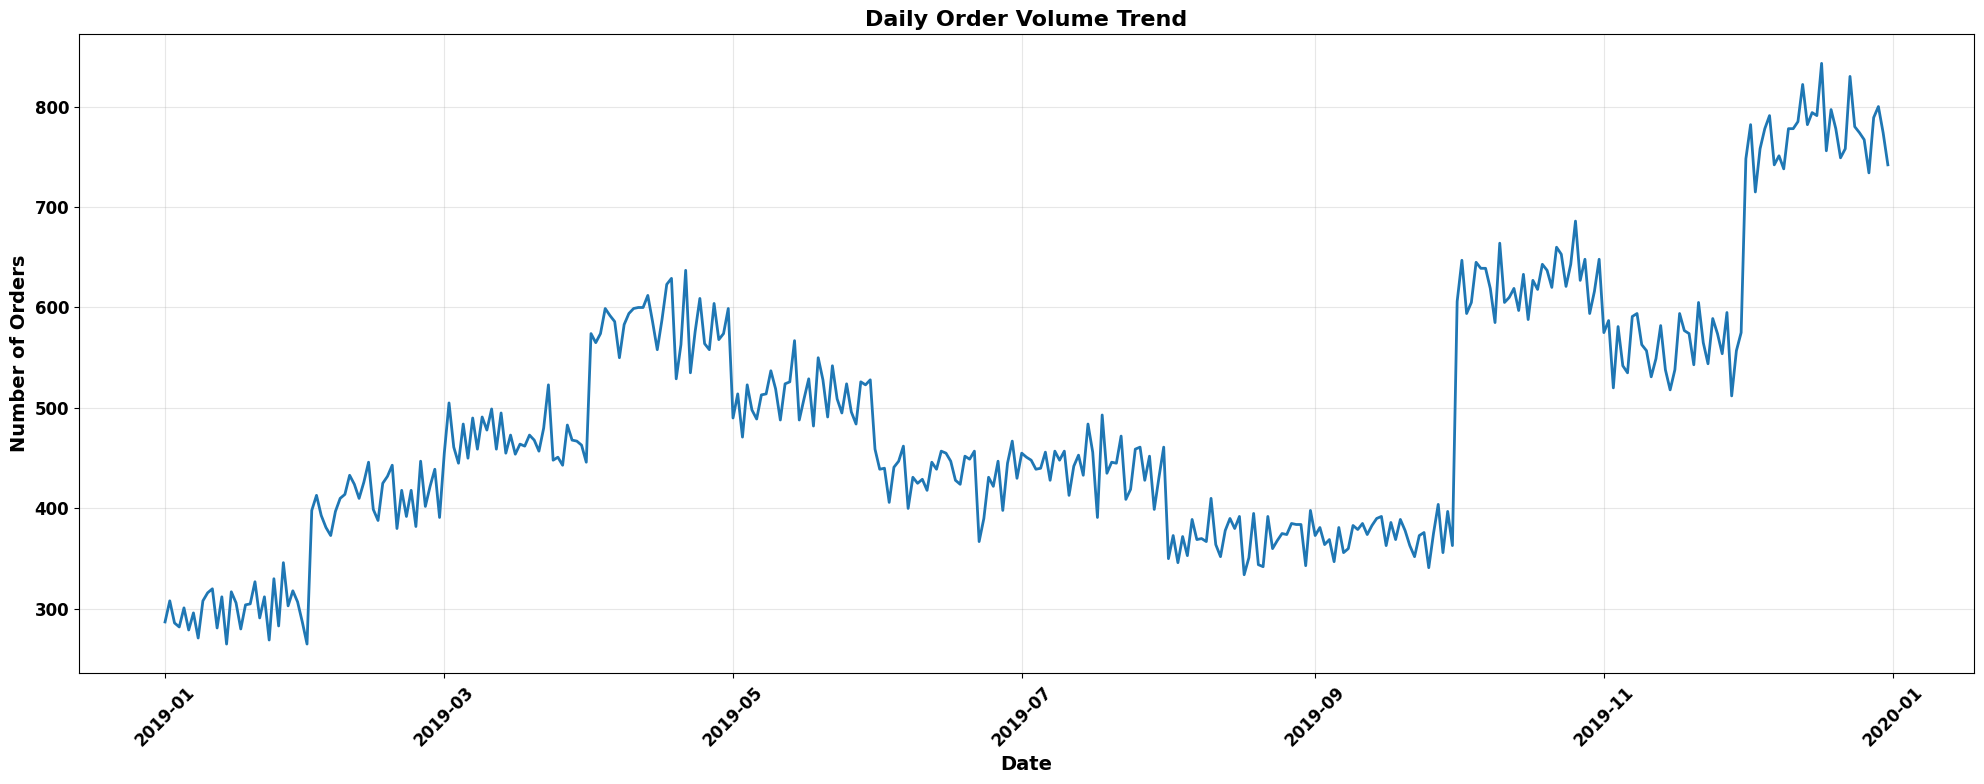

In [60]:
# 1. Daily Order Count Trend
plt.figure(figsize=(20, 8))
daily_orders = daily_data.groupby('OrderDate').size()
plt.plot(daily_orders.index, daily_orders.values, linewidth=2)
plt.title('Daily Order Volume Trend')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(viz_dir / 'daily_order_trend.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

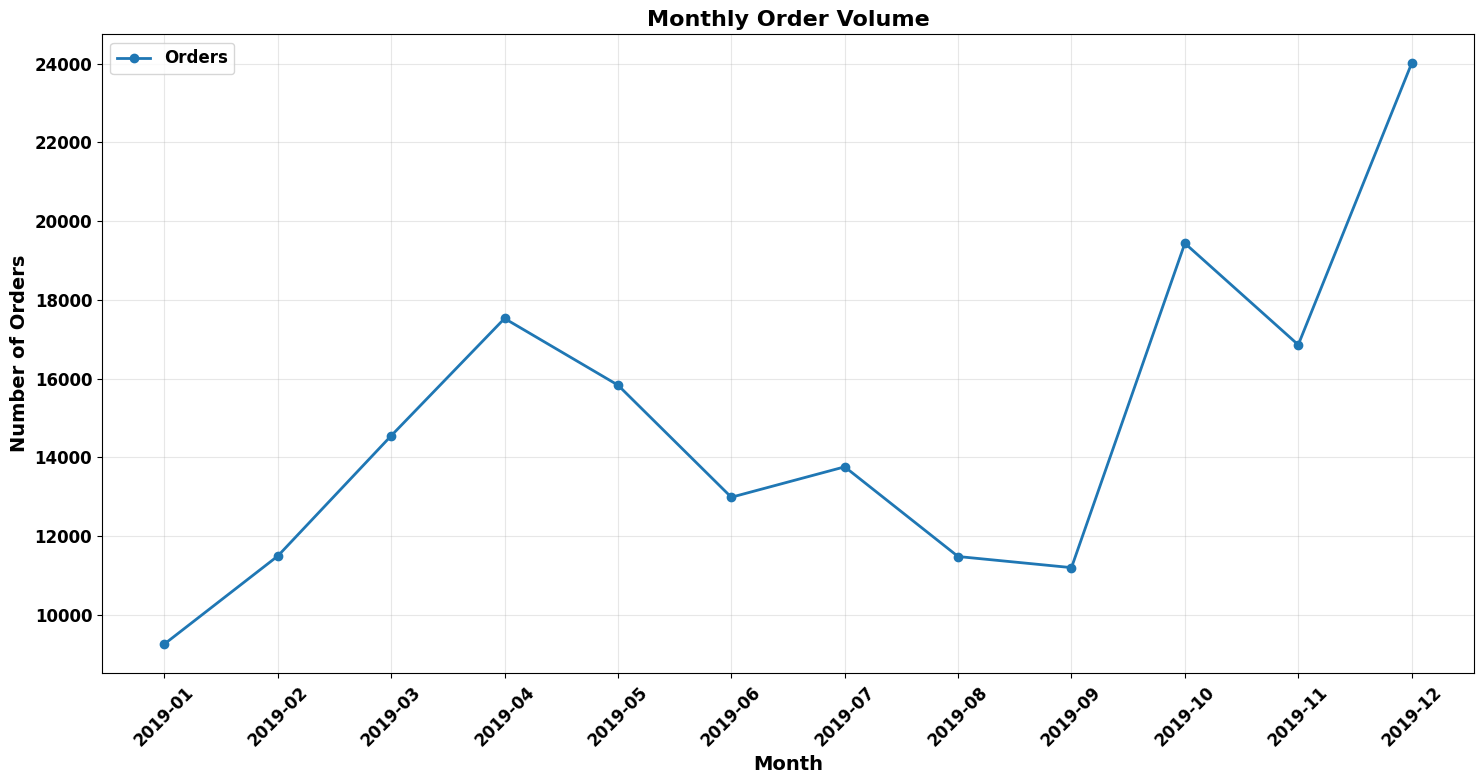

In [61]:
# 2. Monthly Order Metrics
plt.figure(figsize=(15, 8))
x = range(len(monthly_data))
plt.plot(x, monthly_data['Number of Orders'], 'o-', linewidth=2, label='Orders')
plt.title('Monthly Order Volume')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(x, monthly_data['Month'], rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(viz_dir / 'monthly_order_volume.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
        


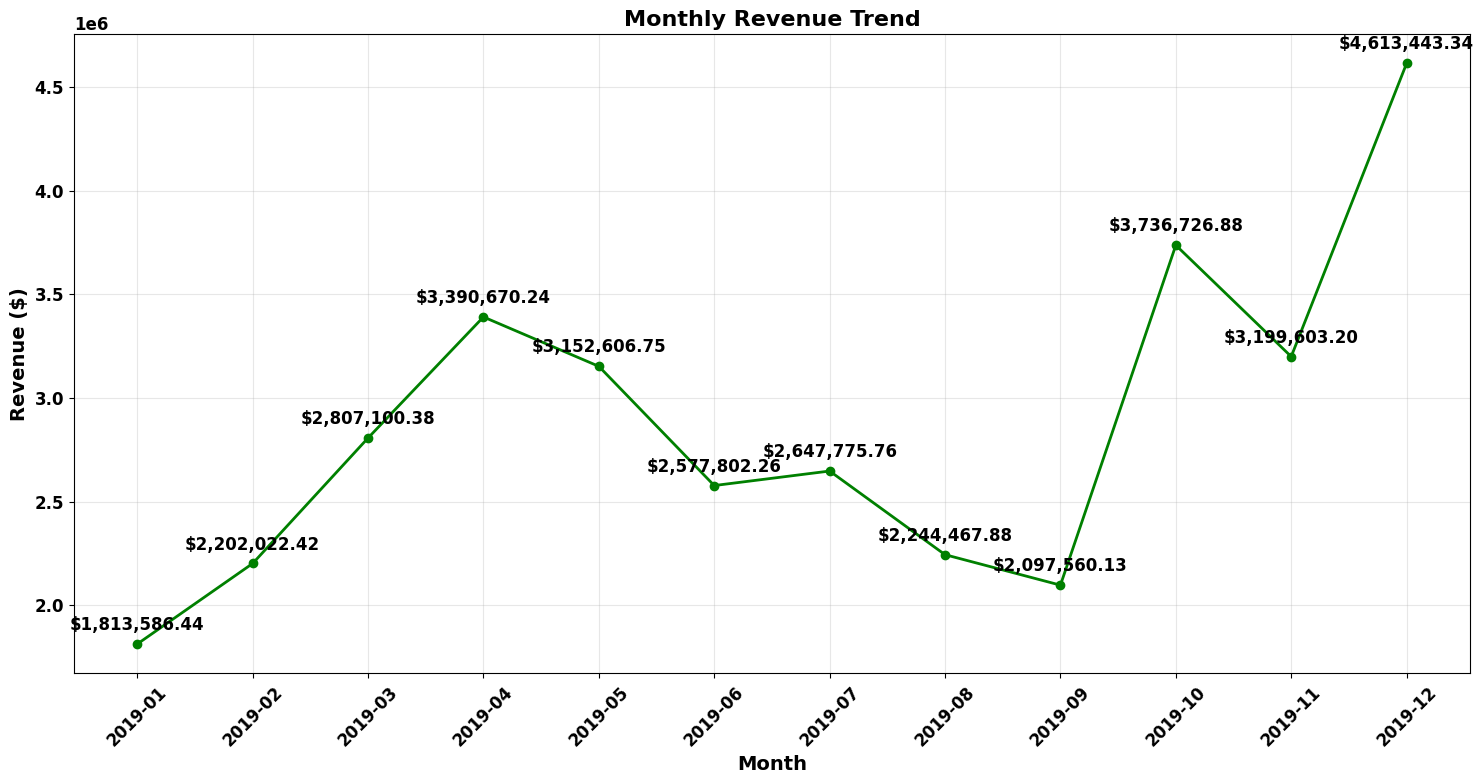

In [62]:
# 3. Monthly Revenue Trend
plt.figure(figsize=(15, 8))
plt.plot(x, monthly_data['Monthly Revenue'], 'o-', linewidth=2, color='green')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.xticks(x, monthly_data['Month'], rotation=45)

for i, rev in enumerate(monthly_data['Monthly Revenue']):
    plt.annotate(f'${rev:,.2f}', (i, rev), textcoords="offset points", 
    xytext=(0,10), ha='center', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(viz_dir / 'monthly_revenue_trend.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()
        

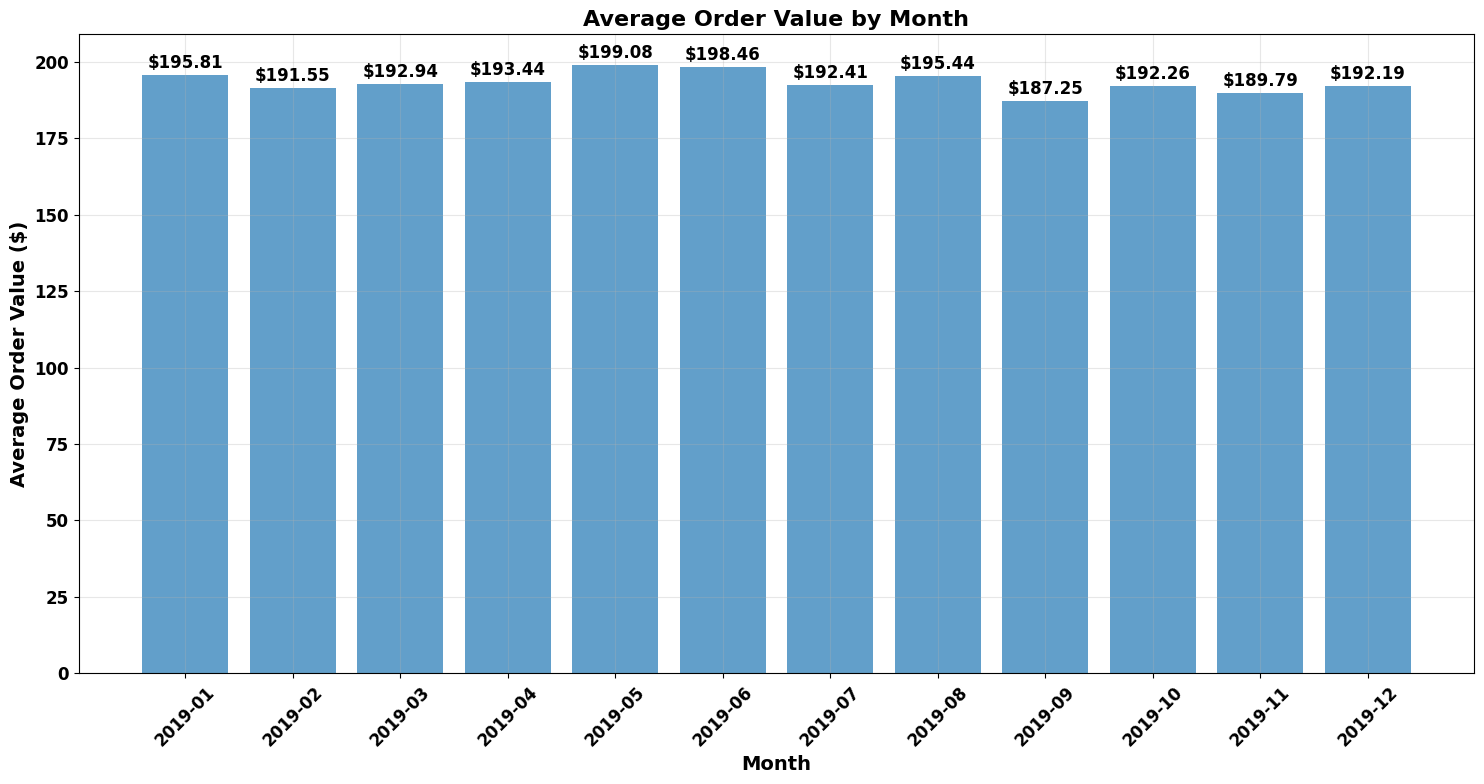

In [63]:
# 4. Average Order Value by Month
plt.figure(figsize=(15, 8))
plt.bar(x, monthly_data['Average Order Value'], alpha=0.7)
plt.title('Average Order Value by Month')
plt.xlabel('Month')
plt.ylabel('Average Order Value ($)')
plt.xticks(x, monthly_data['Month'], rotation=45)
for i, val in enumerate(monthly_data['Average Order Value']):
    plt.annotate(f'${val:.2f}', (i, val), textcoords="offset points", 
                        xytext=(0,5), ha='center', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(viz_dir / 'monthly_avg_order_value.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

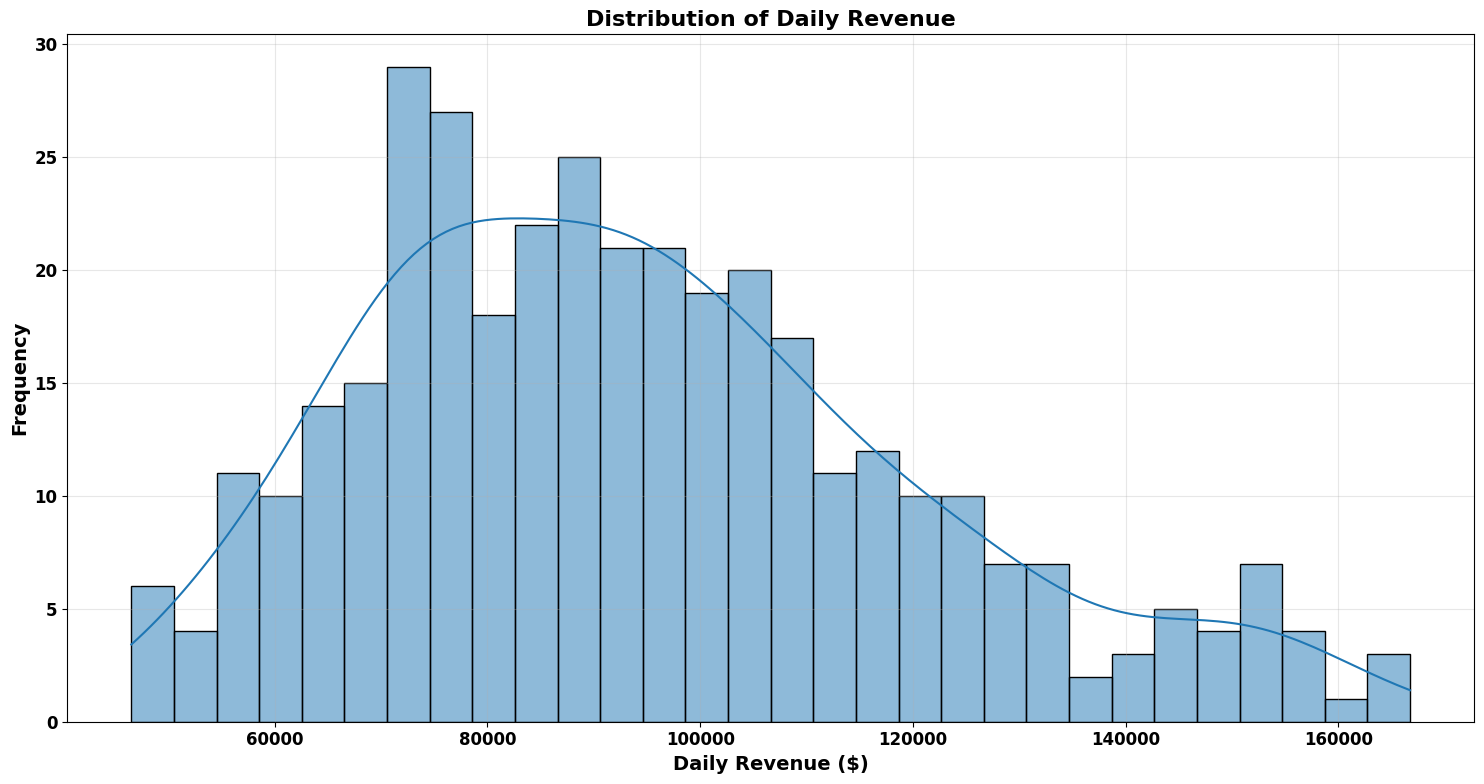

In [64]:
# 5. Daily Revenue Distribution
plt.figure(figsize=(15, 8))
daily_revenue = daily_data.groupby('OrderDate')['Total Revenue'].sum()
sns.histplot(data=daily_revenue, bins=30, kde=True)
plt.title('Distribution of Daily Revenue')
plt.xlabel('Daily Revenue ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(viz_dir / 'daily_revenue_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()        

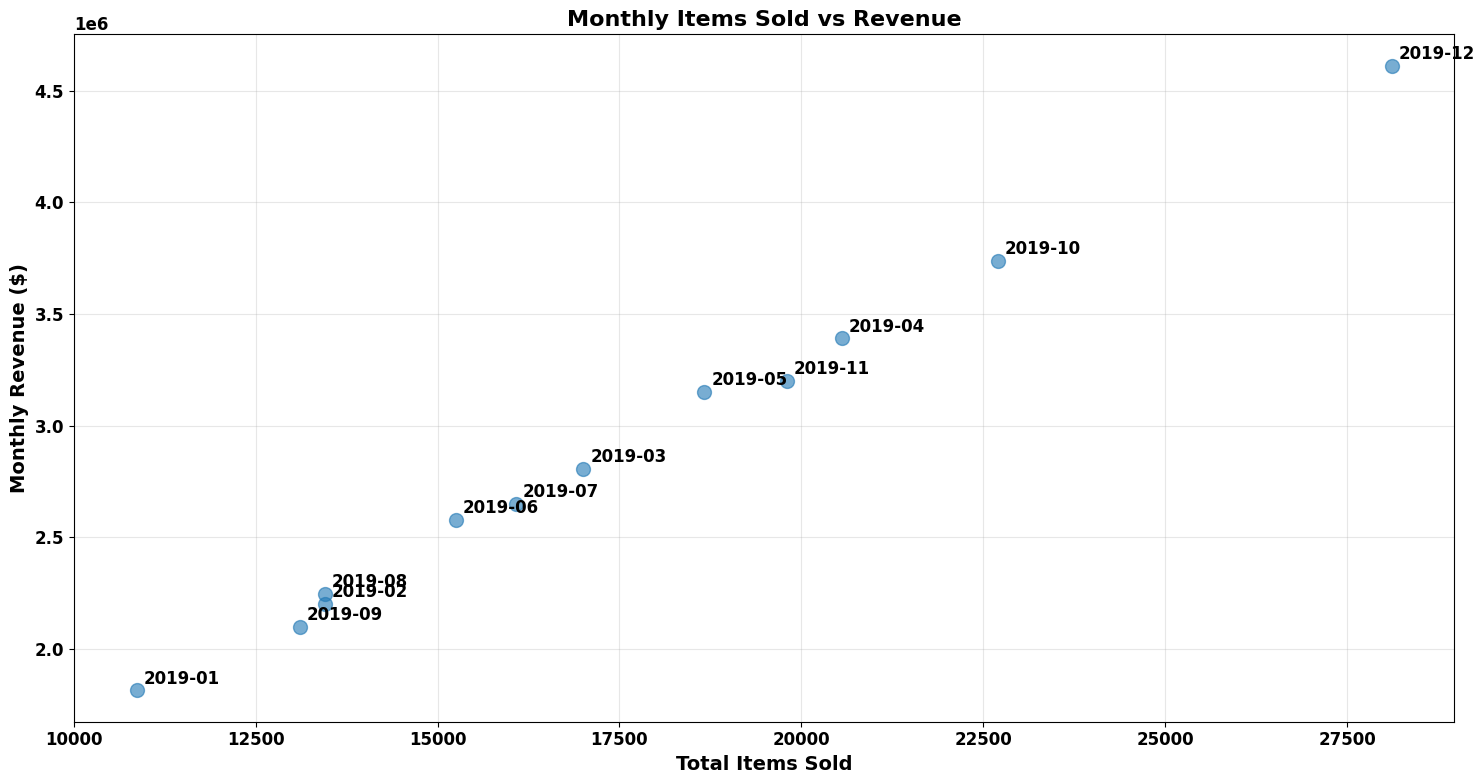

In [65]:
# 6. Monthly Items Sold vs Revenue
plt.figure(figsize=(15, 8))
plt.scatter(monthly_data['Total Items Sold'], monthly_data['Monthly Revenue'], s=100, alpha=0.6)
plt.title('Monthly Items Sold vs Revenue')
plt.xlabel('Total Items Sold')
plt.ylabel('Monthly Revenue ($)')
for i, row in monthly_data.iterrows():
    plt.annotate(row['Month'], (row['Total Items Sold'], row['Monthly Revenue']),
                        xytext=(5, 5), textcoords='offset points')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(viz_dir / 'monthly_items_vs_revenue.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

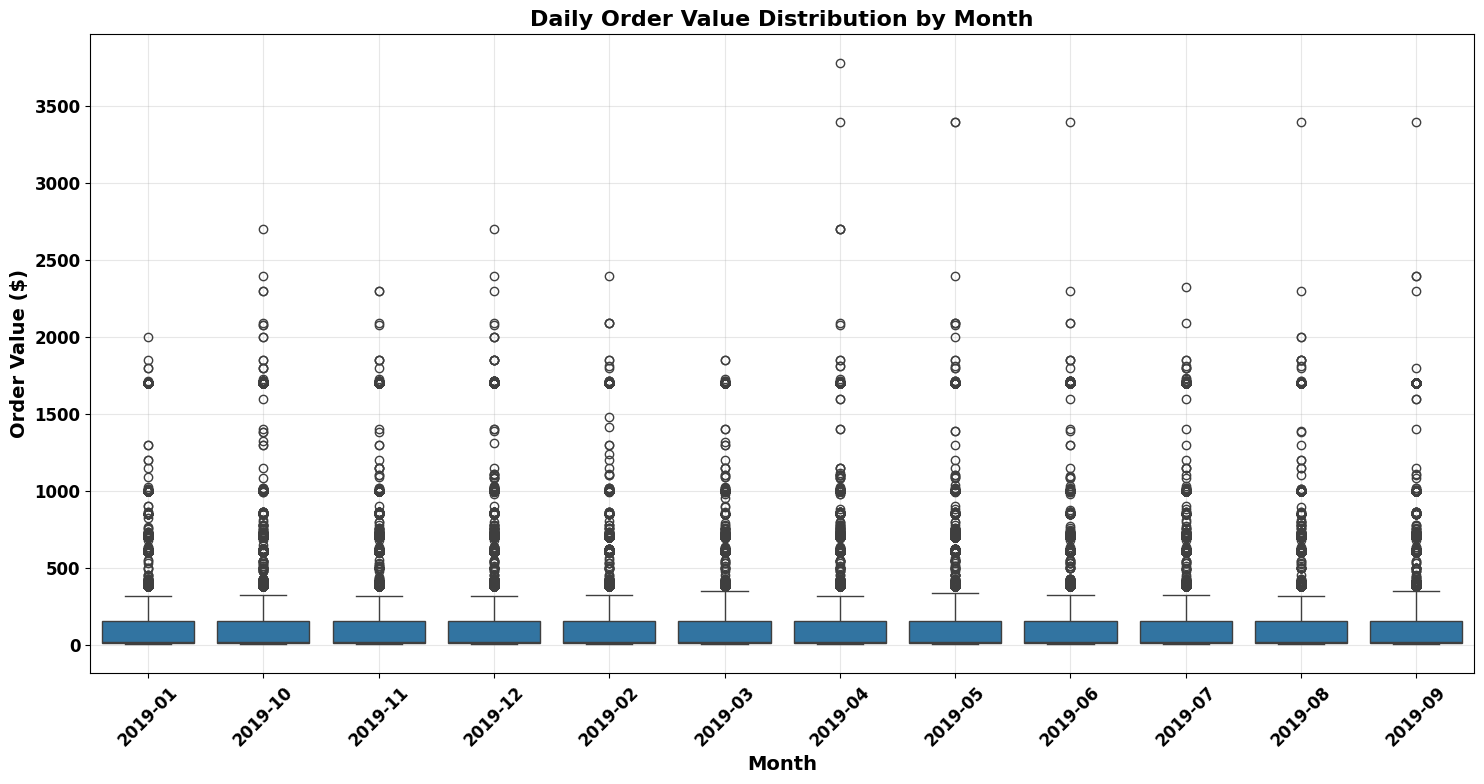

In [66]:
# 7. Daily Order Value Box Plot by Month
plt.figure(figsize=(15, 8))
daily_data['Month'] = daily_data['OrderDate'].dt.strftime('%Y-%m')
sns.boxplot(data=daily_data, x='Month', y='Total Revenue')
plt.title('Daily Order Value Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Order Value ($)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(viz_dir / 'daily_order_value_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [75]:
# Set style parameters for the hourly data Visualizations
file_path = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\ProcessedData\\TimelyAnalysisData\\hourly_patterns.csv')
df_hour = pd.read_csv(file_path)
plt.style.use('default')
plt.rcParams.update({
            'figure.figsize': (15, 8),
            'figure.facecolor': 'white',
            'axes.facecolor': 'white',
            'axes.grid': True,
            'grid.alpha': 0.3,
            'font.family': 'sans-serif',
            'font.size': 12,
            'axes.labelsize': 14,
            'axes.titlesize': 16
        })
        
# Create output directory
output_dir = Path('G:\\Projects\\DataAnalysis\\SalesDataAnalysis\\Visualizations\\HourlyAnalysis')
output_dir.mkdir(parents=True, exist_ok=True)

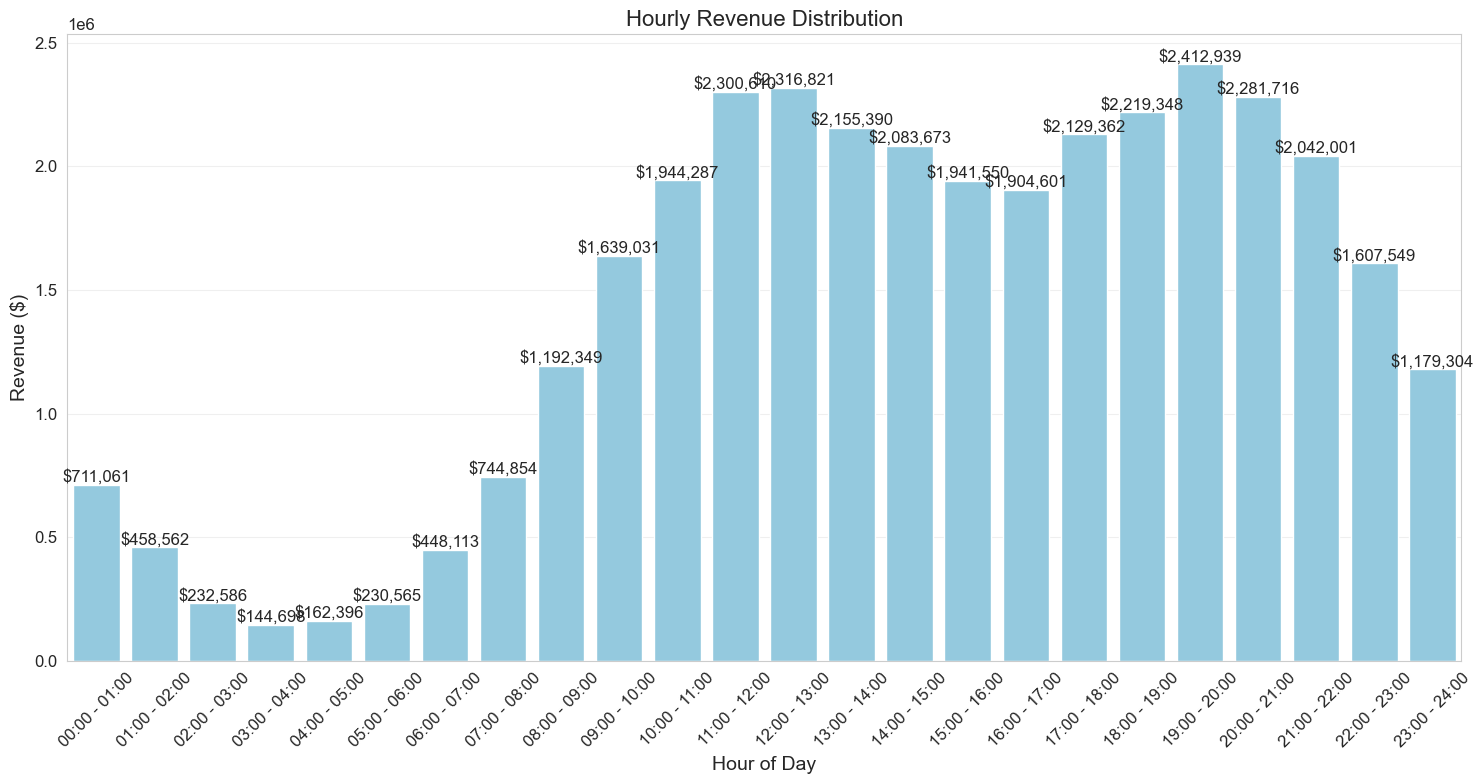

In [78]:
# Set Seaborn style for better visuals
sns.set_style("whitegrid")
        
# 1. Revenue Distribution by Hour
plt.figure()
sns.barplot(data=df_hour, x='Time Range', y='Total Revenue', color='skyblue')
plt.title('Hourly Revenue Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
for i, v in enumerate(df_hour['Total Revenue']):
    plt.text(i, v, f'${v:,.0f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(output_dir / 'hourly_revenue.png', dpi=300, bbox_inches='tight')

plt.show()    
plt.close()

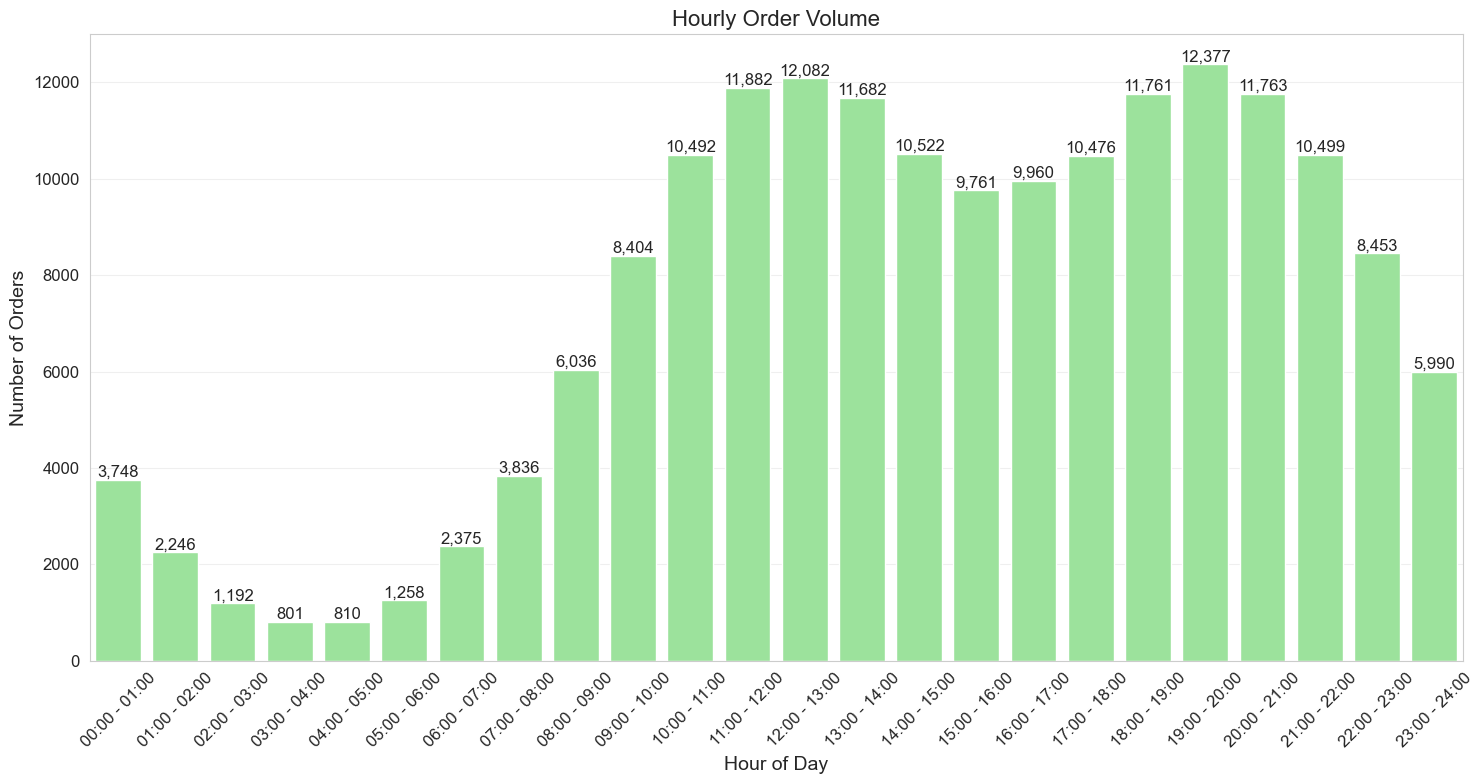

In [80]:
 # 2. Order Volume by Hour
df=df_hour
plt.figure()
sns.barplot(data=df, x='Time Range', y='Number of Orders', color='lightgreen')
plt.title('Hourly Order Volume')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
for i, v in enumerate(df['Number of Orders']):
    plt.text(i, v, f'{int(v):,}', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(output_dir / 'hourly_orders.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

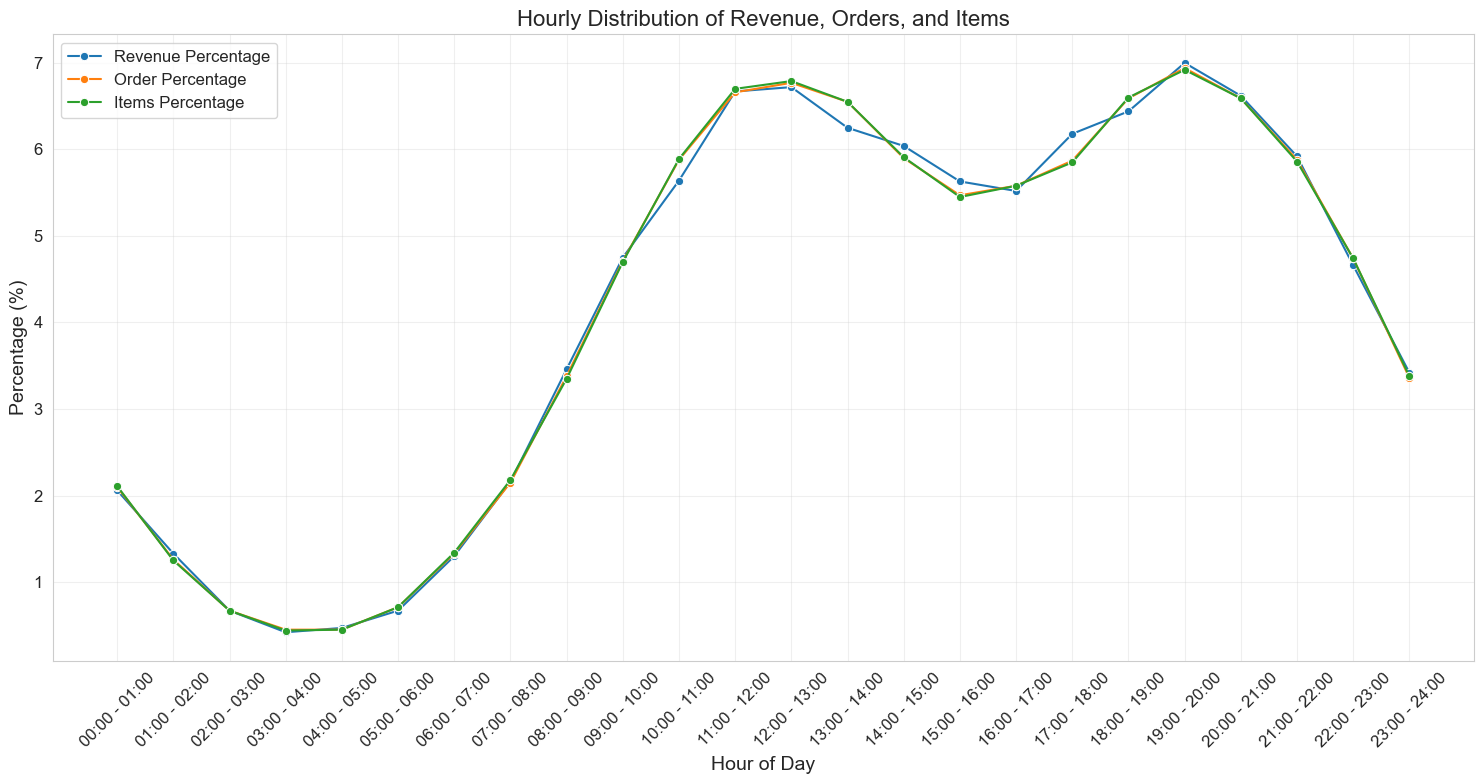

In [81]:
# 3. Percentage Distribution (Line Plot)
plt.figure()
percentage_data = df[['Time Range', 'Revenue Percentage', 'Order Percentage', 'Items Percentage']].melt(
            id_vars=['Time Range'], 
            var_name='Metric', 
            value_name='Percentage'
        )
sns.lineplot(data=percentage_data, x='Time Range', y='Percentage', hue='Metric', marker='o')
plt.title('Hourly Distribution of Revenue, Orders, and Items')
plt.xlabel('Hour of Day')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='')
plt.tight_layout()
plt.savefig(output_dir / 'hourly_percentages.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

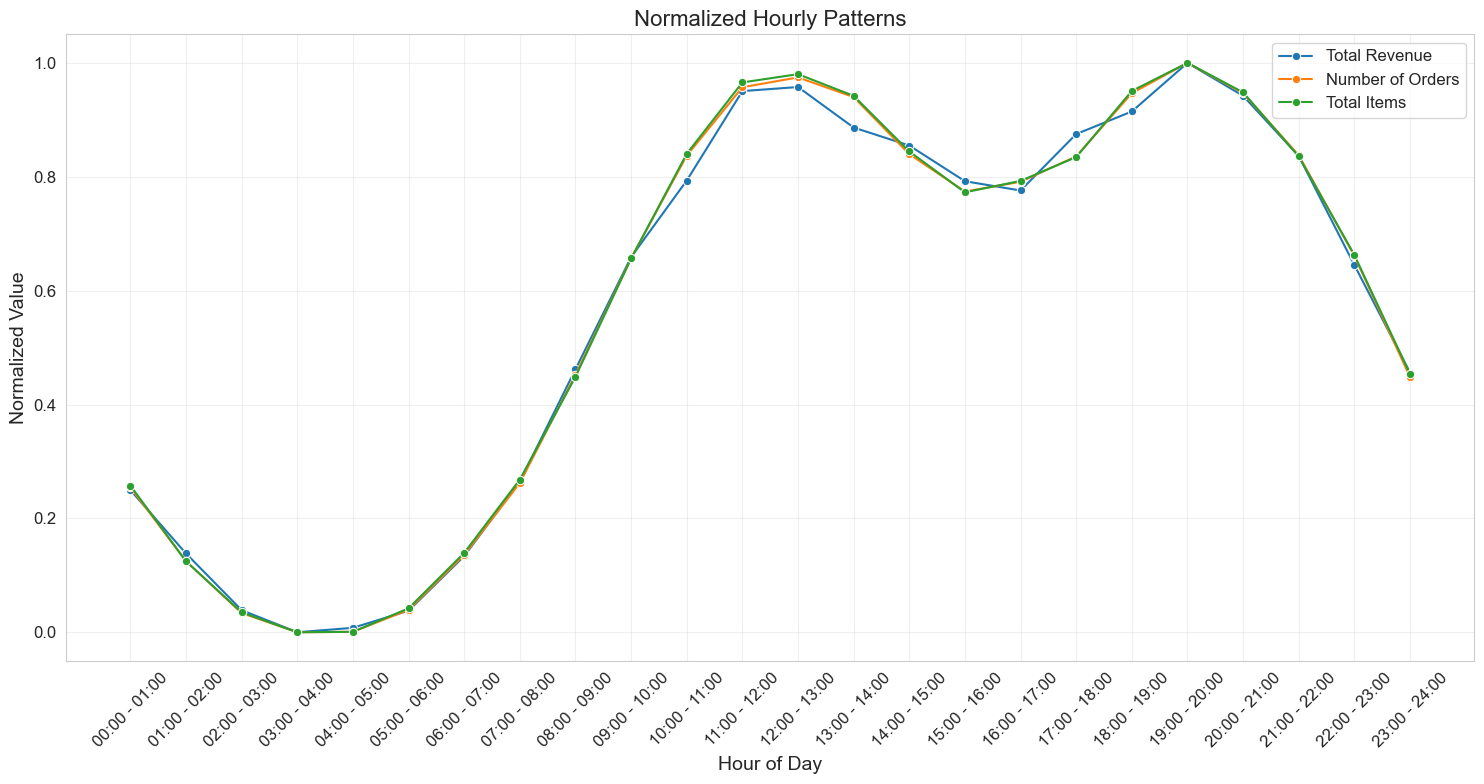

In [82]:
plt.figure()
metrics = ['Total Revenue', 'Number of Orders', 'Total Items']
normalized_data = df[['Time Range'] + metrics].copy()
for metric in metrics:
    normalized_data[metric] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
    normalized_plot_data = normalized_data.melt(
            id_vars=['Time Range'],
            value_vars=metrics,
            var_name='Metric',
            value_name='Normalized Value'
        )
sns.lineplot(data=normalized_plot_data, x='Time Range', y='Normalized Value', hue='Metric', marker='o')
plt.title('Normalized Hourly Patterns')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Value')
plt.xticks(rotation=45)
plt.legend(title='')
plt.tight_layout()
plt.savefig(output_dir / 'normalized_patterns.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()